# DC Motor Speed Control

This example demonstrates multi-domain modeling of a DC motor with PID speed control. The system combines electrical and mechanical dynamics with anti-windup control to handle voltage saturation.

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_dcmotor.py).

## DC Motor Physics

A DC motor is a multi-domain electromechanical system where electrical energy is converted to mechanical rotation. The system consists of two coupled subsystems:

### Electrical Subsystem (Armature Circuit)

The armature circuit dynamics are governed by Kirchhoff's voltage law:

$$V_{applied} = R \cdot i + L \frac{di}{dt} + V_{emf}$$

where:
- $V_{applied}$ is the applied voltage (control input)
- $R$ is the armature resistance
- $L$ is the armature inductance
- $i$ is the armature current
- $V_{emf}$ is the back-EMF (electromotive force)

The back-EMF is proportional to the rotor angular velocity:

$$V_{emf} = K_e \cdot \omega$$

where $K_e$ is the back-EMF constant and $\omega$ is the angular velocity. Rearranging for the current derivative:

$$\frac{di}{dt} = \frac{1}{L}\left(V_{applied} - R \cdot i - K_e \cdot \omega\right)$$

### Mechanical Subsystem (Rotor Dynamics)

The rotor dynamics are described by Newton's second law for rotation:

$$J \frac{d\omega}{dt} = T_{motor} - T_{friction} - T_{load}$$

where:
- $J$ is the rotor moment of inertia
- $T_{motor}$ is the electromagnetic torque
- $T_{friction}$ is the viscous friction torque
- $T_{load}$ is the external load torque

The electromagnetic torque is proportional to the armature current:

$$T_{motor} = K_t \cdot i$$

where $K_t$ is the torque constant. The friction torque is proportional to angular velocity:

$$T_{friction} = B \cdot \omega$$

where $B$ is the viscous friction coefficient. The complete mechanical equation becomes:

$$\frac{d\omega}{dt} = \frac{1}{J}\left(K_t \cdot i - B \cdot \omega - T_{load}\right)$$

### Electromechanical Coupling

The two subsystems are bidirectionally coupled:

- **Electrical → Mechanical**: Current $i$ produces torque $T_{motor} = K_t \cdot i$
- **Mechanical → Electrical**: Angular velocity $\omega$ produces back-EMF $V_{emf} = K_e \cdot \omega$

This coupling creates natural feedback: as the motor speeds up, the back-EMF increases, which opposes the applied voltage and reduces current. At steady-state with no load, the motor reaches an equilibrium where the back-EMF nearly balances the applied voltage.

## PID Speed Control

To control the motor speed, we use a PID (Proportional-Integral-Derivative) controller. The control law is:

$$V_{applied}(t) = K_p e(t) + K_i \int_0^t e(\tau) d\tau + K_d \frac{de(t)}{dt}$$

where $e(t) = \omega_{setpoint}(t) - \omega(t)$ is the speed error.

### Anti-Windup Mechanism

Since the applied voltage is physically limited ($V_{min} \leq V_{applied} \leq V_{max}$), the integrator can "wind up" during saturation, causing overshoot. The anti-windup mechanism modifies the integral term:

$$\frac{d}{dt}\left(\int e\right) = e + K_s(V_{saturated} - V_{unsaturated})$$

where $K_s$ is the anti-windup gain. When saturation occurs, the feedback term prevents further integration.

## Import and Setup

First let's import the required classes and blocks:

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection
from pathsim.blocks import StepSource, Integrator, Amplifier, Adder, Scope, AntiWindupPID, Clip
from pathsim.solvers import RKCK54

## Motor Parameters

In [77]:
# Electrical parameters
R = 1.0          # Armature resistance [Ohm]
L = 0.001        # Armature inductance [H]
K_e = 0.1        # Back-EMF constant [V·s/rad]

# Mechanical parameters
J = 0.01         # Rotor inertia [kg·m²]
B = 0.001        # Viscous friction [N·m·s/rad]
K_t = 0.1        # Torque constant [N·m/A]

# PID controller parameters
Kp, Ki, Kd = 8.0, 15.0, 0.2
f_max = 100      # Derivative filter cutoff [Hz]

# Voltage limits
V_min, V_max = -24, 24

## Source Signals

In [85]:
# Speed setpoint: 50 -> 100 -> 75 -> 50 rad/s
spt_amplitudes = [50, 100, 75, 50]
spt_times = [0, 5, 15, 25]

# Load torque: brief spike then sustained load (negative opposes motion)
load_amplitudes = [0, -0.05, 0, -0.02, 0]
load_times = [0, 10, 12, 20, 30]

## System Definition

Now we construct the multi-domain system with separate electrical and mechanical subsystems:

In [88]:
# Control blocks
spt = StepSource(amplitude=spt_amplitudes, tau=spt_times)
lod = StepSource(amplitude=load_amplitudes, tau=load_times)
err = Adder("+-")
pid = AntiWindupPID(Kp, Ki, Kd, f_max=f_max, Ks=10, limits=[V_min, V_max])
sat = Clip(min_val=V_min, max_val=V_max)

# Electrical subsystem: L * di/dt = V - R*i - K_e*ω
V_R = Amplifier(-R)         # Voltage drop across resistance
V_L = Amplifier(1/L)        # di/dt calculation
emf = Amplifier(-K_e)       # Back-EMF
V_sum = Adder("+++")        # Voltage summation
I_int = Integrator(0)       # Current integrator

# Mechanical subsystem: J * dω/dt = K_t*i - B*ω - T_load
T_m = Amplifier(K_t)        # Motor torque
T_f = Amplifier(-B)         # Friction torque
T_sum = Adder("+++")        # Torque summation
alp = Amplifier(1/J)        # Angular acceleration
omg = Integrator(0)         # Angular velocity integrator

# Measurement
sco1 = Scope(labels=["Setpoint [rad/s]", "Speed [rad/s]"])
sco2 = Scope(labels=["Current [A]", "Voltage [V]"])

blocks = [
    spt, lod, err, pid, sat,
    V_R, V_L, emf, V_sum, I_int,
    T_m, T_f, T_sum, alp, omg,
    sco1, sco2
]

In [90]:
connections = [
    # Control loop
    Connection(spt, err, sco1[0]),
    Connection(omg, err[1], sco1[1]),
    Connection(err, pid),
    Connection(pid, sat),

    # Electrical subsystem
    Connection(sat, V_sum[0], sco2[1]),
    Connection(I_int, V_R),
    Connection(V_R, V_sum[1]),
    Connection(omg, emf),
    Connection(emf, V_sum[2]),
    Connection(V_sum, V_L),
    Connection(V_L, I_int),

    # Mechanical subsystem
    Connection(I_int, T_m, sco2[0]),
    Connection(T_m, T_sum[0]),
    Connection(omg, T_f),
    Connection(T_f, T_sum[1]),
    Connection(lod, T_sum[2]),
    Connection(T_sum, alp),
    Connection(alp, omg)
]

## Simulation Setup and Execution

In [92]:
# Simulation initialization
Sim = Simulation(blocks, connections, Solver=RKCK54)

# Run simulation for 30 seconds
Sim.run(30)

2025-11-02 15:50:32,872 - INFO - LOGGING (log: True)
2025-11-02 15:50:32,873 - INFO - BLOCK (type: StepSource, dynamic: False, events: 1)
2025-11-02 15:50:32,873 - INFO - BLOCK (type: StepSource, dynamic: False, events: 1)
2025-11-02 15:50:32,873 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-11-02 15:50:32,874 - INFO - BLOCK (type: AntiWindupPID, dynamic: True, events: 0)
2025-11-02 15:50:32,874 - INFO - BLOCK (type: Clip, dynamic: False, events: 0)
2025-11-02 15:50:32,874 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:50:32,875 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:50:32,875 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:50:32,875 - INFO - BLOCK (type: Adder, dynamic: False, events: 0)
2025-11-02 15:50:32,876 - INFO - BLOCK (type: Integrator, dynamic: True, events: 0)
2025-11-02 15:50:32,876 - INFO - BLOCK (type: Amplifier, dynamic: False, events: 0)
2025-11-02 15:50:32,877 - INFO 

{'total_steps': 5919,
 'successful_steps': 5027,
 'runtime_ms': 2164.8434000089765}

## Results

Let's plot the speed tracking and electrical signals:

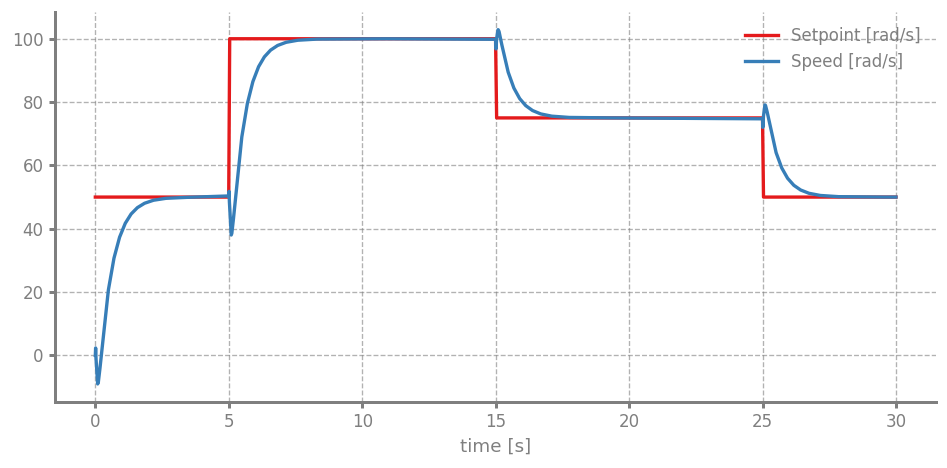

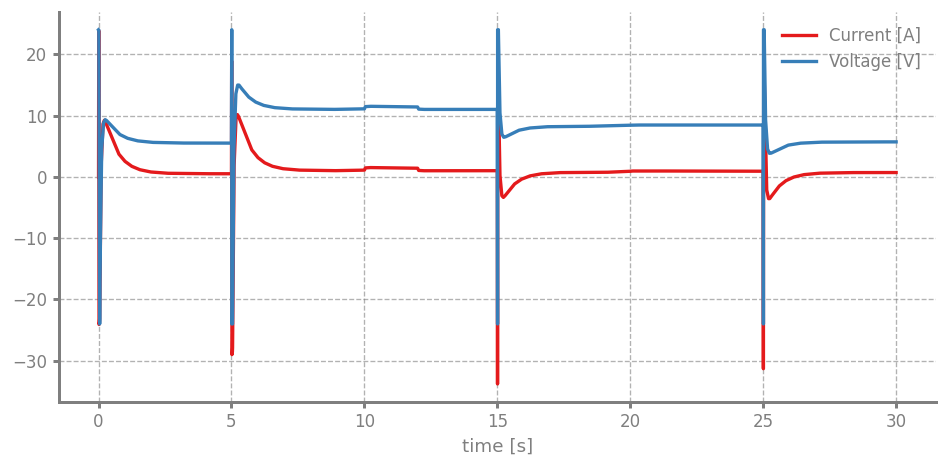

In [95]:
sco1.plot(lw=2)
sco2.plot(lw=2)
plt.show()